In [1]:
from IPython.display import Audio, display

# play a sound whenever an exception is hit
def play_sound(self, etype, value, tb, tb_offset=None):
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    display(Audio("../../sfx.mp3", autoplay=True))
get_ipython().set_custom_exc((Exception,), play_sound)


# put this function at the end of a long cell to play a sound when completed
def beep_completed():
    display(Audio("../../sfx.mp3", autoplay=True))

In [2]:
# baseline imports
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import training_utility

from keras.metrics import mean_squared_error
from keras.models import Sequential, load_model, clone_model
from keras.layers import LSTM, GRU, SimpleRNN, Dense

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

/home/jonathan.gao/.conda/envs/pydda_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reconstructing Model
Due to error on my part (did not save model), I'm manually reconstructing and training the model with the best parameters.

In [3]:
# directories
dirname = "../../!data/pre-loaded/04all_data_16in_4out/"
scalers_path = dirname+"scalers"
study_path = dirname+"study/16in.4out.study.firstattempt"
study2_path = dirname+"16in.4out.study"

In [4]:
file = open(scalers_path, "rb")
scalers = pickle.load(file)
file.close()

file = open(study_path, "rb")
study = pickle.load(file)
file.close()

file = open(study2_path, "rb")
study2 = pickle.load(file)
file.close()

2022-07-21 15:20:02.734954: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 15:20:05.120177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38396 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:90:00.0, compute capability: 8.0


In [19]:
# get y_test since we didn't pickle that oops
# I think this is ok if all data was loaded at once
n_steps_in=16
n_steps_out=4
n_features=2
X_train, X_test, y_train, y_test, scalers = training_utility.get_data(dirname, n_steps_in=n_steps_in, n_steps_out=n_steps_out)
arch = training_utility.Architecture(n_steps_in, n_steps_out, n_features, X_train, X_test, y_train, y_test)

../../!data/pre-loaded/04all_data_16in_4out/all_dates.16.4.15Min.unscaled.y
../../!data/pre-loaded/04all_data_16in_4out/.ipynb_checkpoints
../../!data/pre-loaded/04all_data_16in_4out/.scalers
../../!data/pre-loaded/04all_data_16in_4out/all_dates.16.4.15Min.unscaled.X
../../!data/pre-loaded/04all_data_16in_4out/study
../../!data/pre-loaded/04all_data_16in_4out/reconstructed_model
../../!data/pre-loaded/04all_data_16in_4out/16in.4out.study
../../!data/pre-loaded/04all_data_16in_4out/.reconstructed_model
../../!data/pre-loaded/04all_data_16in_4out/scalers


In [6]:
# using the best parameters, make a new model and train it to get a final evaluation
def build_best_model(study, arch):
    n_neurons = study.best_params["n_neurons"]
    n_layers = study.best_params["n_layers"]
    cell_type = study.best_params["cell_type"]

    if cell_type == "LSTM":
        cell = LSTM
    elif cell_type == "GRU":
        cell = GRU
    else:
        cell = SimpleRNN

    model = Sequential()
    if n_layers == 1:
        model.add(cell(n_neurons, activation="tanh", input_shape=(n_steps_in,n_features)))
    else:
        model.add(cell(n_neurons, activation="tanh", return_sequences=True, input_shape=(n_steps_in,n_features)))
        for i in range(n_layers-2):
            model.add(LSTM(n_neurons, activation="tanh", return_sequences=True))
        model.add(cell(n_neurons))

    model.add(Dense(n_steps_out))
    model.compile(optimizer="adam", loss="mse")
    return model

In [7]:
def train_umbrella(study, arch, n_epochs, min_improvement=-1, patience=0):
    '''
    Primary method for training. Trains for given number of epochs with time series cross validation.
    
            Parameters:
                    trial (optuna trial): Trial, which stores chosen hyperparamters and performance
                    arch (Architecture): Object containing frequently used vars (e.g. n_steps_in, n_features) and training/testing data
                    n_epochs (int): number of epochs to train for
                    min_improvement (int): minimum improvement before early stopping. -1 == do not implement early stopping
                    patience (int): number of iterations to wait for improvement before early stopping
            Returns:
                    model (keras model): Model, trained
                    loss (float): mean squared error, used to measure performance of model
    '''
    print("-----begin training")
    epoch_models = [build_best_model(study, arch)]
    epoch_loss = [np.inf]
    best_idx = 0
    for epoch in range(n_epochs):
        # train one epoch and store loss
        print("-----epoch #" + str(epoch+1))
        model, mse = training_utility.train_epoch(epoch_models[-1], arch.X_train, arch.y_train)
        epoch_models.append(model)
        epoch_loss.append(np.average(mse))
        
        # early stopping:
        if min_improvement >= 0:
            curr_idx = len(epoch_loss) - 1
            if epoch_loss[best_idx] - epoch_loss[-1] >= min_improvement:
                best_idx = curr_idx
                print(f"loss={epoch_loss[-1]}, improvement, best_idx={best_idx}, curr_idx={curr_idx}")
            else:
                print(f"loss={epoch_loss[-1]}, no improvement, best_idx={best_idx}, curr_idx={curr_idx}")
            if curr_idx - best_idx > patience:
                print("-----early stopping. best_idx=" + str(best_idx) + ", curr_idx=" + str(curr_idx))
                break
    
    print(epoch_loss)
    best_idx = np.argmin(epoch_loss)
    return epoch_models[best_idx], epoch_loss

In [8]:
def train_and_evaluate_model(study, arch):
    model, loss_history = train_umbrella(study, arch, n_epochs=140, min_improvement=0, patience=5)
    loss, pred = training_utility.model_eval(model, arch.X_test, arch.y_test, return_pred=True)
    loss = np.average(loss)
    return model, loss, pred, loss_history

In [9]:
model, loss, pred, loss_history = train_and_evaluate_model(study, arch)
beep_completed()

-----begin training
-----epoch #1


2022-07-21 15:20:56.541740: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-07-21 15:21:00.101481: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


939/939 [==============================] - 2s 2ms/step - loss: 0.0125
loss=0.006862175935938492, improvement, best_idx=1, curr_idx=1
-----epoch #2
939/939 [==============================] - 2s 2ms/step - loss: 0.0067
loss=0.0061273899753620095, improvement, best_idx=2, curr_idx=2
-----epoch #3
939/939 [==============================] - 2s 2ms/step - loss: 0.0065
loss=0.0057818449165347304, improvement, best_idx=3, curr_idx=3
-----epoch #4
939/939 [==============================] - 2s 2ms/step - loss: 0.0063
loss=0.005656290160970723, improvement, best_idx=4, curr_idx=4
-----epoch #5
939/939 [==============================] - 3s 2ms/step - loss: 0.0061
loss=0.005366615533858948, improvement, best_idx=5, curr_idx=5
-----epoch #6
939/939 [==============================] - 2s 2ms/step - loss: 0.0060
loss=0.005374808896021322, no improvement, best_idx=5, curr_idx=6
-----epoch #7
939/939 [==============================] - 2s 2ms/step - loss: 0.0059
loss=0.005233632722150533, improvement, bes

939/939 [==============================] - 2s 2ms/step - loss: 0.0053
loss=0.004759753838451048, improvement, best_idx=20, curr_idx=20
-----epoch #21
939/939 [==============================] - 2s 2ms/step - loss: 0.0053
loss=0.0047463860498804245, improvement, best_idx=21, curr_idx=21
-----epoch #22
939/939 [==============================] - 3s 2ms/step - loss: 0.0053
loss=0.004792804595952276, no improvement, best_idx=21, curr_idx=22
-----epoch #23
939/939 [==============================] - 2s 2ms/step - loss: 0.0053
loss=0.0047973626531357325, no improvement, best_idx=21, curr_idx=23
-----epoch #24
939/939 [==============================] - 2s 2ms/step - loss: 0.0053
loss=0.004788273162853109, no improvement, best_idx=21, curr_idx=24
-----epoch #25
939/939 [==============================] - 2s 2ms/step - loss: 0.0053
loss=0.00483615205395734, no improvement, best_idx=21, curr_idx=25
-----epoch #26
939/939 [==============================] - 2s 2ms/step - loss: 0.0053
loss=0.0047238502

In [10]:
# write to file
filename = f"{dirname}reconstructed_model"
file = open(filename, 'wb')
pickle.dump(model, file)
file.close()

2022-07-21 15:29:02.425683: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://c88086d9-b117-4229-bbce-3695c388dbeb/assets


INFO:tensorflow:Assets written to: ram://c88086d9-b117-4229-bbce-3695c388dbeb/assets


# Visualizing Results

In [11]:
# unscale using the scaler for solar irradiance
true_pred = scalers[0].inverse_transform(pred)
true_y_test = scalers[0].inverse_transform(y_test)

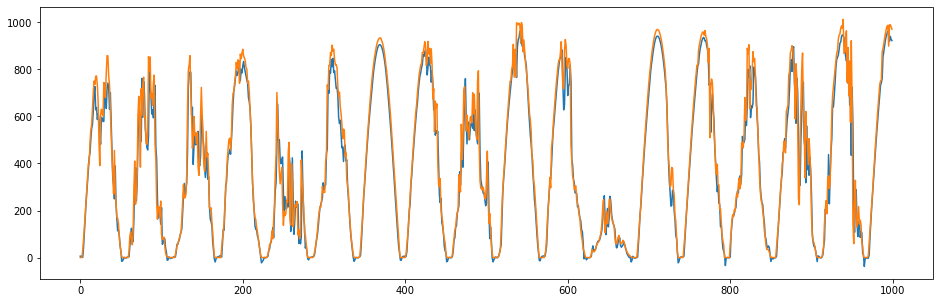

In [12]:
plt.figure(figsize=(16,5))
plot_var = 1000
plt.plot(true_pred[:plot_var,0])
plt.plot(true_y_test[:plot_var,0])

In [13]:
def concatenate_predictions(true_pred, true_y_test, n_days_to_plot, n_days_offset, hours_per_day=14, datapoints_per_day=57): 
    true_pred_comp = np.array([])
    true_y_test_comp = np.array([])
    
    n_iter = hours_per_day * n_days_to_plot
    for i in range(n_iter):
        plot_var = n_steps_out*i + n_days_offset*datapoints_per_day
        true_pred_comp = np.append(true_pred_comp, true_pred[plot_var,:])
        true_y_test_comp = np.append(true_y_test_comp, true_y_test[plot_var,:])
    
    # fencepost error. add one datapoint
    true_pred_comp = np.append(true_pred_comp, true_pred[n_steps_out*n_iter + n_days_offset*datapoints_per_day,0])
    true_y_test_comp = np.append(true_y_test_comp, true_y_test[n_steps_out*n_iter + n_days_offset*datapoints_per_day,0])
    
    return true_pred_comp, true_y_test_comp

In [48]:
def plot_concatenated(true_pred_comp, true_y_test_comp, n_days_to_plot, small=False, hours_per_day=14):
    if small:
        plt.figure(figsize=(16,8))
        plt.rcParams.update({'font.size': 24})
    else:
        plt.rcParams.update({'font.size': 18})
        plt.figure(figsize=(34,16))
    plt.plot(true_pred_comp)
    plt.plot(true_y_test_comp)
    plt.xlabel("Hours")
    plt.ylabel("Solar Irradiance (Watts/m^2)")
    plt.legend(["Prediction","Actual"])
    plt.xticks(np.arange(0, hours_per_day * n_days_to_plot * n_steps_out + 1, 4.0))
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    plt.grid(True)

In [35]:
def plot_range(n_days_to_plot, n_days_offset):
    true_pred_comp, true_y_test_comp = concatenate_predictions(true_pred, true_y_test, n_days_to_plot, n_days_offset)
    plot_concatenated(true_pred_comp, true_y_test_comp, n_days_to_plot, small=False)

In [34]:
def plot_specific(day_idx):
    n_days_to_plot=1
    true_pred_comp, true_y_test_comp = concatenate_predictions(true_pred, true_y_test, n_days_to_plot, n_days_offset=day_idx)
    plot_concatenated(true_pred_comp, true_y_test_comp, n_days_to_plot, small=True)

6


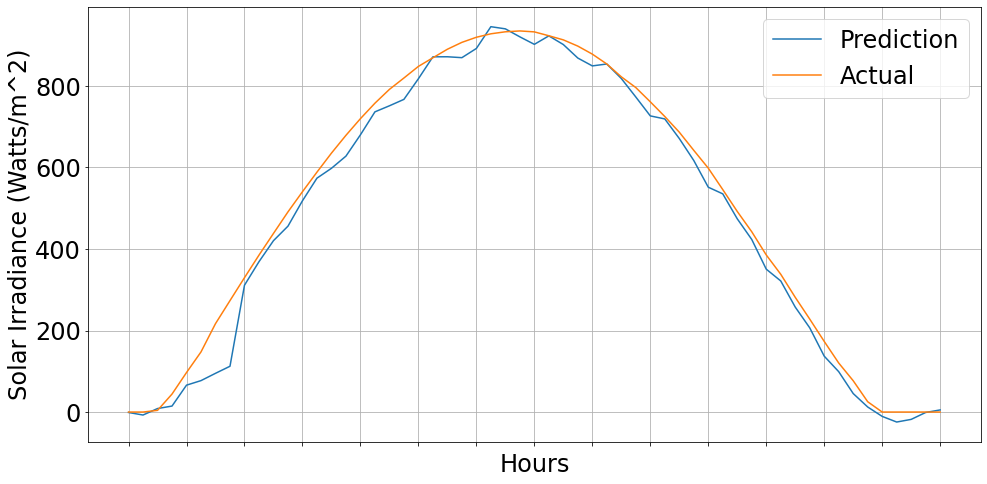

11


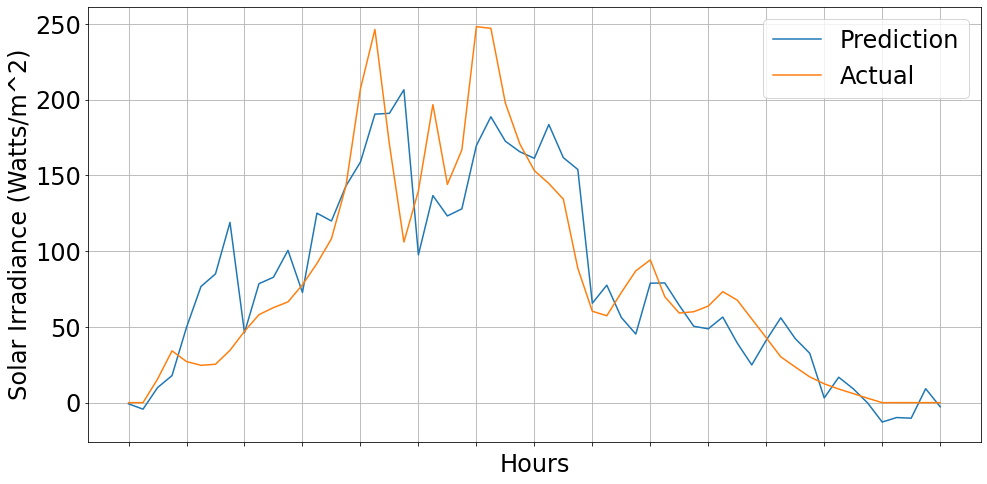

[6, 0]


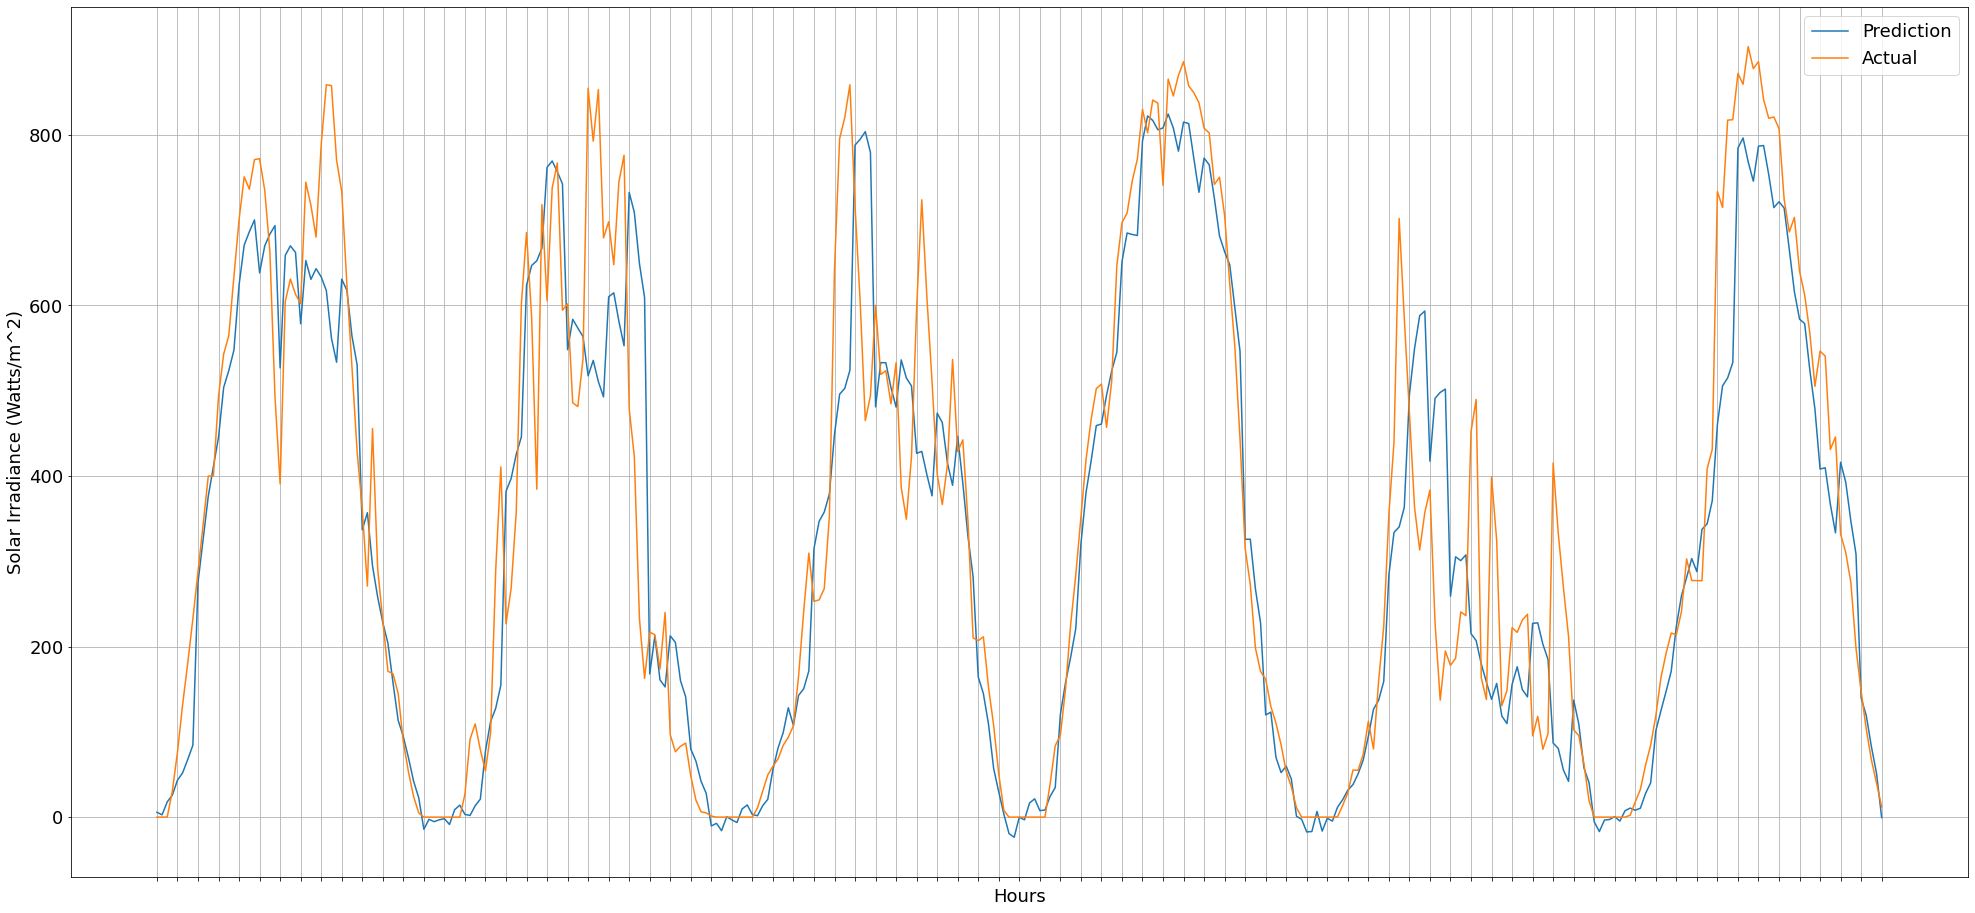

In [49]:
# every hour is predicted by the past 4 hours. e.g., the hour from 0 to 1 is predicted from the data of the 4 hours before
juicy_days = [6, 11, [6,0]]
for juicy_day in juicy_days:
    print(juicy_day)
    
    if isinstance(juicy_day, int):
        plot_specific(juicy_day)
    else:
        plot_range(juicy_day[0], juicy_day[1])
    
    plt.savefig(f'graph_images/{juicy_day}.png', bbox_inches='tight')
    plt.show()

In [5]:
def get_trials_table(study, study_name):
    df = pd.DataFrame()

    for trial in study.trials:
        df_dictionary = pd.DataFrame([trial.params])
        df_dictionary["loss"] = trial.value
        df_dictionary["study_name"] = study_name
        df = pd.concat([df, df_dictionary], ignore_index=True)
    return df

In [6]:
def clean_table(df):
    df['rank'] = df['loss'].rank(ascending=True).astype(int)
    df = df.reindex(['rank','cell_type', 'n_layers', 'n_neurons','loss','study_name'], axis=1)
    df = df.sort_values(by=['rank','cell_type', 'n_layers', 'n_neurons'])
    df = df.rename(columns={"cell_type": "cell type", "n_layers": "layers", "n_neurons": "neurons"})
    df = df.replace(['SimpleRNN'],'RNN')
    return df

In [7]:
df1 = get_trials_table(study, 1)
df2 = get_trials_table(study2, 2)
df = clean_table(pd.concat([df1,df2]))

df

2022-07-21 12:55:43.111130: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://c9b0b84c-e3e0-47f2-a36c-207732f71128/assets


INFO:tensorflow:Assets written to: ram://c9b0b84c-e3e0-47f2-a36c-207732f71128/assets


INFO:tensorflow:Assets written to: ram://e7b35339-2d80-4c32-8696-cd44fe40dc0e/assets


INFO:tensorflow:Assets written to: ram://e7b35339-2d80-4c32-8696-cd44fe40dc0e/assets


INFO:tensorflow:Assets written to: ram://2a125fed-f460-4794-8e29-b7a7b08d1ed0/assets


INFO:tensorflow:Assets written to: ram://2a125fed-f460-4794-8e29-b7a7b08d1ed0/assets


INFO:tensorflow:Assets written to: ram://6b1dd452-fa0e-42a5-882a-092a2f21a8d2/assets


INFO:tensorflow:Assets written to: ram://6b1dd452-fa0e-42a5-882a-092a2f21a8d2/assets


INFO:tensorflow:Assets written to: ram://31bb383f-eea7-46c4-bf16-2e48a162594c/assets


INFO:tensorflow:Assets written to: ram://31bb383f-eea7-46c4-bf16-2e48a162594c/assets


INFO:tensorflow:Assets written to: ram://f11209fd-3c21-41d9-8f81-59f7ad1a2a25/assets


INFO:tensorflow:Assets written to: ram://f11209fd-3c21-41d9-8f81-59f7ad1a2a25/assets


INFO:tensorflow:Assets written to: ram://2632f4c5-59ab-45e6-ae59-455b9416cd05/assets


INFO:tensorflow:Assets written to: ram://2632f4c5-59ab-45e6-ae59-455b9416cd05/assets


INFO:tensorflow:Assets written to: ram://318290eb-afbe-4420-b621-cb4f083ff897/assets


INFO:tensorflow:Assets written to: ram://318290eb-afbe-4420-b621-cb4f083ff897/assets


INFO:tensorflow:Assets written to: ram://32b896cc-377b-42f5-a109-d122b8a1c362/assets


INFO:tensorflow:Assets written to: ram://32b896cc-377b-42f5-a109-d122b8a1c362/assets


INFO:tensorflow:Assets written to: ram://7ac875ac-5d51-4b0d-929b-beab894c0f34/assets


INFO:tensorflow:Assets written to: ram://7ac875ac-5d51-4b0d-929b-beab894c0f34/assets


INFO:tensorflow:Assets written to: ram://fadca9b1-c788-41fa-9823-24a66f4f4adc/assets


INFO:tensorflow:Assets written to: ram://fadca9b1-c788-41fa-9823-24a66f4f4adc/assets


INFO:tensorflow:Assets written to: ram://e0921002-c7ce-46bb-b016-47dca51e0be2/assets


INFO:tensorflow:Assets written to: ram://e0921002-c7ce-46bb-b016-47dca51e0be2/assets


INFO:tensorflow:Assets written to: ram://5599dd91-af97-4bac-b030-ddf299881e64/assets


INFO:tensorflow:Assets written to: ram://5599dd91-af97-4bac-b030-ddf299881e64/assets


INFO:tensorflow:Assets written to: ram://8e07f81e-b96f-4e71-af23-990091b88fe3/assets


INFO:tensorflow:Assets written to: ram://8e07f81e-b96f-4e71-af23-990091b88fe3/assets


INFO:tensorflow:Assets written to: ram://70f78d81-1a04-44bc-a5c9-9b8359d7010c/assets


INFO:tensorflow:Assets written to: ram://70f78d81-1a04-44bc-a5c9-9b8359d7010c/assets


INFO:tensorflow:Assets written to: ram://917032e8-1292-4b1b-906b-687ee9270ad1/assets


INFO:tensorflow:Assets written to: ram://917032e8-1292-4b1b-906b-687ee9270ad1/assets


INFO:tensorflow:Assets written to: ram://0d8a278a-f263-411e-9886-577648a72864/assets


INFO:tensorflow:Assets written to: ram://0d8a278a-f263-411e-9886-577648a72864/assets


INFO:tensorflow:Assets written to: ram://a2ecd3ba-a218-4670-8bdc-584f973023a9/assets


INFO:tensorflow:Assets written to: ram://a2ecd3ba-a218-4670-8bdc-584f973023a9/assets


INFO:tensorflow:Assets written to: ram://4d0bb92d-909b-4a14-b44b-e38455dd860a/assets


INFO:tensorflow:Assets written to: ram://4d0bb92d-909b-4a14-b44b-e38455dd860a/assets


INFO:tensorflow:Assets written to: ram://39d864d4-bac5-40fb-8605-a57cc486c920/assets


INFO:tensorflow:Assets written to: ram://39d864d4-bac5-40fb-8605-a57cc486c920/assets


,rank,cell type,layers,neurons,loss,study_name
14,1,GRU,1,32,0.004806,1
0,2,GRU,2,32,0.004825,1
14,3,LSTM,4,32,0.004837,2
12,4,GRU,1,32,0.004866,1
10,5,LSTM,4,32,0.004895,2
11,6,GRU,1,32,0.004949,1
2,7,RNN,2,32,0.004961,2
8,8,RNN,1,128,0.005107,1
5,9,RNN,1,64,0.005218,1
4,10,RNN,2,64,0.005225,2


<AxesSubplot:xlabel='layers'>

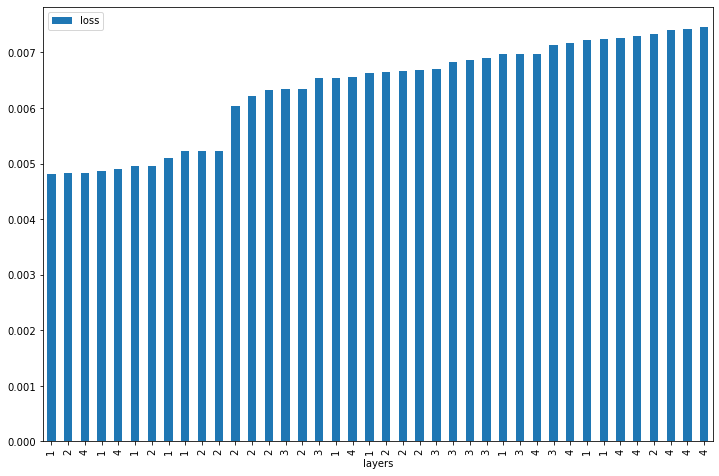

In [56]:
scatter = df.copy()
# scatter = scatter[scatter['cell type']=='GRU']
# scatter['loss'] = 600 * (scatter['loss'] - scatter['loss'].min())/(scatter['loss'].max() - scatter['loss'].min())
# scatter.plot.scatter(x='layers',y='neurons',s='loss')
scatter.plot.bar(x='layers',y='loss',figsize=(12,8))